## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### **Exploration and Data Analysis**

In [4]:
# import lets plot
import numpy as np
from lets_plot import *
LetsPlot.setup_html()

In [5]:
# How big is this dataset?
df.shape

(404290, 6)

In [6]:
# What portion of our questions are actually duplicate?
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [7]:
# plot class distribution for each class using ggplot2
ggplot(df, aes(x='is_duplicate', fill = 'is_duplicate')) + geom_bar() + ggtitle(" ") + labs(x="Class", y="Count") +\
scale_fill_discrete(guide='none') + \
theme_classic() + \
flavor_high_contrast_dark() 


In [8]:
# Are we missing any data?
print('Number of nulls in label: {}'.format(df['is_duplicate'].isnull().sum()))
print('Number of nulls in text: {}'.format(df['question1'].isnull().sum()))
print('Number of nulls in text: {}'.format(df['question2'].isnull().sum()))

Number of nulls in label: 0
Number of nulls in text: 1
Number of nulls in text: 2


In [9]:
# How many unique questions are there?
print('Total number of question pairs for training: {}'.format(len(df)))

Total number of question pairs for training: 404290


In [10]:
# count how many times a question appears in the df
qids = pd.Series(df[df['qid1'].notnull()]['qid1'].tolist() + df[df['qid2'].notnull()]['qid2'].tolist())

In [11]:
# plot distribution of of qids using ggplot2
ggplot(qids, aes(x=qids)) + geom_density(binwidth=10, method='histodot') + ggtitle(" ") + labs(x="Question ID", y="Count")

In [12]:
# concat question1 and question2 into a single string
questions = df['question1'].astype(str) + " " + df['question2'].astype(str).tolist()

In [13]:
questions = questions.apply(len)

In [14]:
# Get min, max, mean, and standard deviation of a list of numbers
def min_max_mean_std(numbers):
    mean = sum(numbers) / len(numbers)
    std = (sum([(x - mean) ** 2 for x in numbers]) / len(numbers)) ** 0.5
    return mean, std

In [15]:
# call function on questions list
mean, std = min_max_mean_std(questions)
print(mean, std)

120.6450963417349 55.00734920633935


In [16]:
min(questions), max(questions), mean, std

(6, 1319, 120.6450963417349, 55.00734920633935)

In [17]:
# plot distribution of questions using ggplot2
ggplot(questions, aes(x=questions)) + \
    geom_histogram(bins = 100, fill = 'white') +\
          ggtitle(" ") + labs(x="Question Length", y="Count") + \
          theme_classic() + \
            flavor_high_contrast_dark() 
            

In [18]:
# add a new column to the dataframe with the length of each question
df['characters'] = questions

In [19]:
# word count for each question
questions = df['question1'].astype(str) + " " + df['question2'].astype(str).tolist()

# split questions into words

In [20]:
questions = questions.apply(lambda x: x.lower().split())

In [21]:
questions = questions.apply(len)

In [22]:
mean, std = min_max_mean_std(questions)

In [23]:
min(questions), max(questions), mean, std

(2, 270, 22.124200450171905, 10.074891656619457)

In [24]:
# plot distribution of questions using ggplot2
ggplot(questions, aes(x=questions)) + \
    geom_histogram(bins = 100, fill = 'white') +\
          ggtitle(" ") + labs(x="Question Word Length", y="Count") + \
          theme_classic() + \
            flavor_high_contrast_dark()

From here, I will drop those questions that have 99 words and less than 15 characters.

In [25]:
df['words'] = questions

In [26]:
#Remove id and qid1 and qid2
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [27]:
df.head()

,question1,question2,is_duplicate,characters,words
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,124,26
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,140,21
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,133,24
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,116,20
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,116,20


In [28]:
# convert is_duplicate as yes or no
df['is_duplicate'] = df['is_duplicate'].apply(lambda x: 'yes' if x == 1 else 'no')

In [33]:
x = df['words']
ggplot(df, aes(x='words', fill='is_duplicate')) + ggsize(700, 400) + \
geom_density(color='orange', alpha=.7) + scale_fill_discrete(guide='none') + \
theme_classic() + \
flavor_high_contrast_dark() + \
ggsize(1024, 768)

In [34]:
# from here i will drop rows where words are less than 10 and greater than 67 words. 

df = df[df['words'] > 5]
df = df[df['words'] < 67]

df.shape

(402691, 5)

In [37]:
# plot class distribution for each class using ggplot2
x = df['words']
ggplot(df, aes(x='words', fill='is_duplicate')) + ggsize(1024, 768) + \
geom_density(color='black', alpha=.7) + scale_fill_discrete(guide='none') + \
theme_classic() + \
flavor_high_contrast_dark()

In [38]:
df['is_duplicate'] = df['is_duplicate'].apply(lambda x: 1 if x == 'yes' else 0)

In [39]:
# fill the missing values with empty strings
df = df.fillna(' ')
df.head()

,question1,question2,is_duplicate,characters,words
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,124,26
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,140,21
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,133,24
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,116,20
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,116,20


In [40]:
# drop characters and words columns
df.drop(['characters', 'words'], axis=1)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...
404285,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,What is one coin?,What's this coin?,0
404288,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [42]:
import re #regular expression
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

2023-06-06 14:19:34.183786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
# Remove punctuation
import string
string.punctuation

def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text


In [44]:
df['q1_clean'] = df['question1'].apply(lambda x: remove_punct(x))
df['q2_clean'] = df['question2'].apply(lambda x: remove_punct(x))

In [45]:
df.drop(['question1', 'question2'], axis=1, inplace=True)

In [46]:
# Remove Alpha Numeric
def remove_alphanumeric(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [47]:
# apply function to data frame
df['q1_clean'] = df['q1_clean'].apply(lambda x: remove_alphanumeric(x))
df['q2_clean'] = df['q2_clean'].apply(lambda x: remove_alphanumeric(x))

In [48]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text.split() if word.lower() not in (stop)]
    return " ".join(text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# remove stopwords from questions
df['q1_clean'] = df['q1_clean'].apply(lambda x: remove_stopwords(x))
df['q2_clean'] = df['q2_clean'].apply(lambda x: remove_stopwords(x))

df.head(3)

,is_duplicate,characters,words,q1_clean,q2_clean
0,0,124,26,step step guide invest share market india,step step guide invest share market
1,0,140,21,story Kohinoor KohiNoor Diamond,would happen Indian government stole Kohinoor ...
2,0,133,24,increase speed internet connection using VPN,Internet speed increased hacking DNS


In [50]:
# remove unwanted spaces and convert to lower case
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag

# define class to remove unwanted spaces and convert to lower case
class CleanText(object):
    def __init__(self, text):
        self.text = text
        
    def clean(self):
        # remove unwanted spaces and convert to lower case
        self.text = self.text.lower()
        self.text = self.text.strip()
        return self.text


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [51]:
# call class to remove unwanted spaces and convert to lower case for q1_clean and q2_clean
df['q1_clean'] = df['q1_clean'].apply(lambda x: CleanText(x).clean())
df['q2_clean'] = df['q2_clean'].apply(lambda x: CleanText(x).clean())

df.head(3)

,is_duplicate,characters,words,q1_clean,q2_clean
0,0,124,26,step step guide invest share market india,step step guide invest share market
1,0,140,21,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,0,133,24,increase speed internet connection using vpn,internet speed increased hacking dns


In [52]:
 from copy import deepcopy


In [53]:
df_A = deepcopy(df)

In [54]:
df_A.head(3)

,is_duplicate,characters,words,q1_clean,q2_clean
0,0,124,26,step step guide invest share market india,step step guide invest share market
1,0,140,21,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,0,133,24,increase speed internet connection using vpn,internet speed increased hacking dns


In [55]:
# combine q1_clean and q2_clean into a single column called "combined" using string concatenation
df_A['combined'] = df_A['q1_clean'].astype(str) +' ' + df_A['q2_clean'].astype(str)



In [56]:
df_A.head(3)

,is_duplicate,characters,words,q1_clean,q2_clean,combined
0,0,124,26,step step guide invest share market india,step step guide invest share market,step step guide invest share market india step...
1,0,140,21,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,story kohinoor kohinoor diamond would happen i...
2,0,133,24,increase speed internet connection using vpn,internet speed increased hacking dns,increase speed internet connection using vpn i...


In [57]:
# drop q1_clean and q2_clean

df_A.drop(['q1_clean', 'q2_clean'], axis=1, inplace=True)
df_A.head()

,is_duplicate,characters,words,combined
0,0,124,26,step step guide invest share market india step...
1,0,140,21,story kohinoor kohinoor diamond would happen i...
2,0,133,24,increase speed internet connection using vpn i...
3,0,116,20,mentally lonely solve find remainder mathmath ...
4,0,116,20,one dissolve water quikly sugar salt methane c...


In [58]:
df_A.to_csv('df_A.csv', index=False)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [60]:
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/Users/patrick/opt/anaconda3/envs/Python_3_9/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [61]:
target = df['is_duplicate']

In [62]:
# create a dataframe with target
X = pd.DataFrame(target)

In [63]:
# calculate the length of questions and apply to X df
X['q1_len'] = df['q1_clean'].apply(lambda x: len(x))
X['q2_len'] = df['q2_clean'].apply(lambda x: len(x))

In [64]:
# calculate weight of each word in corpus
def get_weight(count, eps=10000, min_count=2):
    return 0 if count < min_count else 1 / (count + eps)

# join all questions together
pairs_qs = df['q1_clean'].str.split().astype(str) + df['q2_clean'].str.split().astype(str) 
words = (" ".join(pairs_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}


In [65]:
X['word_count'] = pairs_qs.apply(lambda x: len(str(x).split()))

In [69]:
# import spacy
nlp = spacy.load('en_core_web_sm')

In [70]:
# find the number of unique words in each question
def unique_words(text):
    doc = nlp(text)
    unique_words = set([token.text for token in doc if token.is_stop != True and token.is_punct != True])
    return len(unique_words)

# find common words in each question
def common_words(text):
    doc = nlp(text)
    common_words = set([token.text for token in doc if token.is_stop == True and token.is_punct == True])
    return len(common_words)

In [71]:
X.head(3)

,is_duplicate,q1_len,q2_len,word_count
0,0,41,35,12
1,0,31,67,12
2,0,44,36,10


In [72]:
stopwords = nltk.corpus.stopwords.words('english')

In [73]:
%%time
nlp = spacy.load('en_core_web_sm')
stops = set(nltk.corpus.stopwords.words("english"))

def word_shares(row):
    q1_list = str(row['q1_clean']).lower().split()
    q1 = set(q1_list)
    q1words = q1.difference(stops)
    if len(q1words) == 0:
        return '0:0:0:0:0:0:0:0:0'

    q2_list = str(row['q2_clean']).lower().split()
    q2 = set(q2_list)
    q2words = q2.difference(stops)
    if len(q2words) == 0:
        return '0:0:0:0:0:0:0:0:0'

    words_hamming = sum(1 for i in zip(q1_list, q2_list) if i[0]==i[1])/max(len(q1_list), len(q2_list))

    q1stops = q1.intersection(stops)
    q2stops = q2.intersection(stops)

    q1_2gram = set([i for i in zip(q1_list, q1_list[1:])])
    q2_2gram = set([i for i in zip(q2_list, q2_list[1:])])

    shared_2gram = q1_2gram.intersection(q2_2gram)

    shared_words = q1words.intersection(q2words)
    shared_weights = [weights.get(w, 0) for w in shared_words]
    q1_weights = [weights.get(w, 0) for w in q1words]
    q2_weights = [weights.get(w, 0) for w in q2words]
    total_weights = q1_weights + q1_weights

    R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
    R2 = len(shared_words) / (len(q1words) + len(q2words) - len(shared_words)) #count share
    R31 = len(q1stops) / len(q1words) #stops in q1
    R32 = len(q2stops) / len(q2words) #stops in q2
    Rcosine_denominator = (np.sqrt(np.dot(q1_weights,q1_weights))*np.sqrt(np.dot(q2_weights,q2_weights)))
    Rcosine = np.dot(shared_weights, shared_weights)/Rcosine_denominator
    if len(q1_2gram) + len(q2_2gram) == 0:
        R2gram = 0
    else:
        R2gram = len(shared_2gram) / (len(q1_2gram) + len(q2_2gram))
    
    fuzzy_match = fuzz.token_sort_ratio(q1_list, q2_list)
    
    return '{}:{}:{}:{}:{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32, R2gram, 
                                                  Rcosine, words_hamming, fuzzy_match)

X['word_shares'] = df.apply(word_shares, axis=1)


<timed exec>:33: RuntimeWarning: invalid value encountered in long_scalars
<timed exec>:38: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:33: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:38: RuntimeWarning: invalid value encountered in divide


CPU times: user 1min 2s, sys: 365 ms, total: 1min 3s
Wall time: 1min 3s


In [74]:
X.head(3)

,is_duplicate,q1_len,q2_len,word_count,word_shares
0,0,41,35,12,nan:0.8333333333333334:5:0.0:0.0:0.45454545454...
1,0,31,67,12,nan:0.2222222222222222:2:0.0:0.0:0.18181818181...
2,0,44,36,10,nan:0.2222222222222222:2:0.0:0.0:0.0:nan:0.166...


In [75]:
X['word_match']       = X['word_shares'].apply(lambda x: float(x.split(':')[0]))
X['tfidf_word_match'] = X['word_shares'].apply(lambda x: float(x.split(':')[1]))
X['shared_count']     = X['word_shares'].apply(lambda x: float(x.split(':')[2]))

X['stops1_ratio']     = X['word_shares'].apply(lambda x: float(x.split(':')[3]))
X['stops2_ratio']     = X['word_shares'].apply(lambda x: float(x.split(':')[4]))
X['shared_2gram']     = X['word_shares'].apply(lambda x: float(x.split(':')[5]))
X['cosine']           = X['word_shares'].apply(lambda x: float(x.split(':')[6]))
X['words_hamming']    = X['word_shares'].apply(lambda x: float(x.split(':')[7]))
X['fuzzy_match']    = X['word_shares'].apply(lambda x: float(x.split(':')[8]))


X['len_word_q1'] = df['q1_clean'].apply(lambda x: len(str(x).split()))
X['len_word_q2'] = df['q2_clean'].apply(lambda x: len(str(x).split()))
X['diff_len_word'] = X['len_word_q1'] - X['len_word_q2']

In [76]:
X.head(3)

,is_duplicate,q1_len,q2_len,word_count,word_shares,word_match,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,cosine,words_hamming,fuzzy_match,len_word_q1,len_word_q2,diff_len_word
0,0,41,35,12,nan:0.8333333333333334:5:0.0:0.0:0.45454545454...,NaN,0.833333,5.0,0.0,0.0,0.454545,NaN,0.857143,92.0,7,6,1
1,0,31,67,12,nan:0.2222222222222222:2:0.0:0.0:0.18181818181...,NaN,0.222222,2.0,0.0,0.0,0.181818,NaN,0.000000,59.0,4,9,-5
2,0,44,36,10,nan:0.2222222222222222:2:0.0:0.0:0.0:nan:0.166...,NaN,0.222222,2.0,0.0,0.0,0.000000,NaN,0.166667,65.0,6,5,1


In [77]:
# drop word_shares column
X.drop(['word_shares'], axis=1, inplace=True)

In [78]:
# get unique values in cosine column
X['cosine'].unique()

array([nan,  0.])

In [79]:
X.drop(['cosine'], axis=1, inplace=True)


In [80]:
X['word_match'].unique()

array([nan,  0.])

In [81]:
X.drop(['word_match'], axis=1, inplace=True)

In [82]:
X.head(3)

,is_duplicate,q1_len,q2_len,word_count,tfidf_word_match,shared_count,stops1_ratio,stops2_ratio,shared_2gram,words_hamming,fuzzy_match,len_word_q1,len_word_q2,diff_len_word
0,0,41,35,12,0.833333,5.0,0.0,0.0,0.454545,0.857143,92.0,7,6,1
1,0,31,67,12,0.222222,2.0,0.0,0.0,0.181818,0.000000,59.0,4,9,-5
2,0,44,36,10,0.222222,2.0,0.0,0.0,0.000000,0.166667,65.0,6,5,1


In [98]:
#X.drop(['stops1_ratio', 'stops2_ratio'], axis=1, inplace=True)
X.drop(['q2_len'], axis = 1, inplace=True)

In [99]:
data = X.corr().reset_index()

In [100]:
# plot correlation matrix using ggplot
from lets_plot.bistro.corr import *
plot = corr_plot(data, flip = False, threshold = 0.0, show_legend= False).points().tiles().labels().build() + theme_classic() + flavor_high_contrast_dark() + ggtitle(''' ''') + ggsize(1366, 700)

plot

/Users/patrick/opt/anaconda3/envs/Python_3_9/lib/python3.9/site-packages/lets_plot/bistro/corr.py:422: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.corr()


In [101]:
# export to csv
X.to_csv('clean_df.csv')

In [102]:
import pandas as pd

In [122]:
df = pd.read_csv('clean_df.csv', index_col=0)

In [123]:
# take the first 10000 rows from df sample data using iloc
sample = df.iloc[:10000]
sample.head(3)

,is_duplicate,word_count,tfidf_word_match,shared_count,shared_2gram,words_hamming,fuzzy_match,len_word_q1,len_word_q2,diff_len_word
0,0,12,0.833333,5.0,0.454545,0.857143,92.0,7,6,1
1,0,12,0.222222,2.0,0.181818,0.000000,59.0,4,9,-5
2,0,10,0.222222,2.0,0.000000,0.166667,65.0,6,5,1


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# import standard scaler
from sklearn.preprocessing import StandardScaler

# import stratified k fold
from sklearn.model_selection import StratifiedKFold

# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# import pipeline
from sklearn.pipeline import Pipeline

# import smote from imblearn
from imblearn.over_sampling import SMOTE


In [125]:
y = sample['is_duplicate']
X = sample.drop(['is_duplicate'], axis=1)

In [126]:
sm = SMOTE(random_state=42)

In [121]:
# X, y = sm.fit_resample(X, y)


In [127]:
# split the data into train and test using 80:20 ratio using iloc
y_train = y.iloc[:int(y.shape[0]*0.8)]
y_test = y.iloc[int(y.shape[0]*0.8):]
X_train = X.iloc[:int(X.shape[0]*0.8)]
X_test = X.iloc[int(X.shape[0]*0.8):]


In [128]:
y_train.shape, y_test.shape, X_train.shape, X_test.shape

((8000,), (2000,), (8000, 9), (2000, 9))

1. Test different models

In [129]:
scoring = 'accuracy'
kfold = StratifiedKFold(n_splits=10)

In [130]:
# build pipeline without scaling
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))


results = []
names = []
#evaluate each model in turn with cross validation
for name, model in models:
    model.fit(X_train, y_train)
    results.append(accuracy_score(y_test, model.predict(X_test)))
    names.append(name)
    msg = f'{name}: {results}'
    print(msg)


/Users/patrick/opt/anaconda3/envs/Python_3_9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR: [0.6755]
RF: [0.6755, 0.6905]


In [131]:
# plot the results
import matplotlib.pyplot as plt

# get confusion matrix
print(classification_report(y_test, model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.76      0.75      0.76      1274
           1       0.57      0.59      0.58       726

    accuracy                           0.69      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.69      0.69      0.69      2000



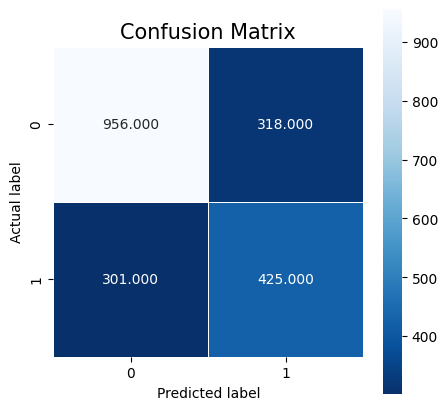

In [132]:
# plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()


In [133]:
# import xgboost
import xgboost as xgb

In [134]:
# xgb classifier with learning rate 0.01
Xgb = xgb.XGBClassifier()
Xgb.fit(X_train, y_train)
y_pred = Xgb.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1274
           1       0.58      0.59      0.59       726

    accuracy                           0.70      2000
   macro avg       0.67      0.68      0.67      2000
weighted avg       0.70      0.70      0.70      2000

[[966 308]
 [296 430]]
0.698


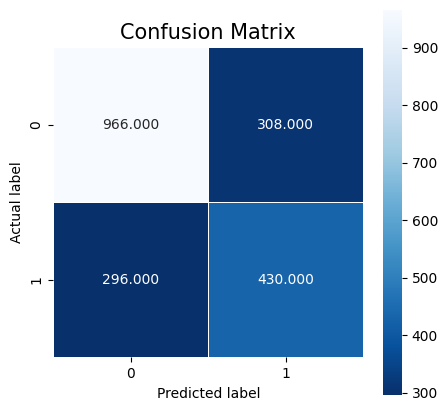

In [135]:
# get confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()

In [86]:
# grid_search(X_train, y_train, X_test, y_test)

In [136]:
# scaled random forest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# build pipeline with scaling
pipe = Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier())])

pipe.fit(X_train, y_train)
print(pipe.score(X_test, y_test))


0.6835


In [137]:
# grid search for random forest
from sklearn.model_selection import GridSearchCV

# define parameters
param_grid = {'rfc__n_estimators': [10, 100, 1000], 'rfc__max_depth': [5, 10, 15, 20, 25, 30], 'rfc__min_samples_leaf': [1, 2, 4]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/patrick/opt/anaconda3/envs/Python_3_9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [14]:
X_train.shape[1]

11

In [56]:
# LSTM model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import numpy as np
import pandas as pd
from keras import layers


model = Sequential()
model.add(Dense(110, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='LeakyReLU'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 110)               1320      
                                                                 
 dropout_4 (Dropout)         (None, 110)               0         
                                                                 
 dense_7 (Dense)             (None, 500)               55500     
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               50100     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 30)               

In [57]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=120,batch_size=300, verbose=1,)

Epoch 1/120
334/334 [==============================] - 4s 10ms/step - loss: 0.6807 - accuracy: 0.6214 - val_loss: 0.8308 - val_accuracy: 0.0000e+00
Epoch 2/120
334/334 [==============================] - 3s 10ms/step - loss: 0.6650 - accuracy: 0.6250 - val_loss: 0.9227 - val_accuracy: 0.0000e+00
Epoch 3/120
334/334 [==============================] - 3s 10ms/step - loss: 0.6620 - accuracy: 0.6250 - val_loss: 0.9650 - val_accuracy: 0.0000e+00
Epoch 4/120
334/334 [==============================] - 3s 10ms/step - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.9791 - val_accuracy: 0.0000e+00
Epoch 5/120
334/334 [==============================] - 3s 10ms/step - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.9798 - val_accuracy: 0.0000e+00
Epoch 6/120
334/334 [==============================] - 3s 9ms/step - loss: 0.6616 - accuracy: 0.6250 - val_loss: 0.9787 - val_accuracy: 0.0000e+00
Epoch 7/120
334/334 [==============================] - 3s 9ms/step - loss: 0.6616 - accuracy: 0.6250 - val_loss: 

KeyboardInterrupt: 

In [23]:
# clear session to avoid clutter from old models / layers.
from keras import backend as K 
K.clear_session()

In [ ]:
# Neural Net Using RAW Data

import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('df_A.csv')

In [ ]:
# take sample of first 10000 rows from df sample data using iloc
sample = df.iloc[:10000]

In [ ]:
sample.head()

In [ ]:
X = sample['combined']
y = sample['is_duplicate']

In [ ]:
y_train = y.iloc[:int(y.shape[0]*0.8)]
y_test = y.iloc[int(y.shape[0]*0.8):]
X_train = X.iloc[:int(X.shape[0]*0.8)]
X_test = X.iloc[int(X.shape[0]*0.8):]

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
print(X_train[5])

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
X_train[1]

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))